In [1]:
import os
import gc
import time
import numpy as np
import pandas as pd
from contextlib import contextmanager
import multiprocessing
from functools import partial
from scipy.stats import kurtosis, iqr, skew
from lightgbm import LGBMClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
pd.set_option('display.max_rows', 60)

In [3]:
pd.set_option('display.max_columns', 100)

In [4]:
debug = True

In [5]:
num_rows = 30000 if debug else None

In [6]:
# df = get_train_test(DATA_DIRECTORY, num_rows= num_rows)

In [7]:
# NUM_THREADS = 4
DATA_DIRECTORY = "../input/"
# SUBMISSION_SUFIX = "_model2_04"

In [8]:
path = DATA_DIRECTORY
num_rows = num_rows

In [9]:
os.path.join(path, 'application_train.csv')

'../input/application_train.csv'

In [10]:
train = pd.read_csv('application_train.csv', nrows=num_rows)
test = pd.read_csv('application_test.csv', nrows=num_rows)

In [11]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,...,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,...,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,...,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single /

<Axes: >

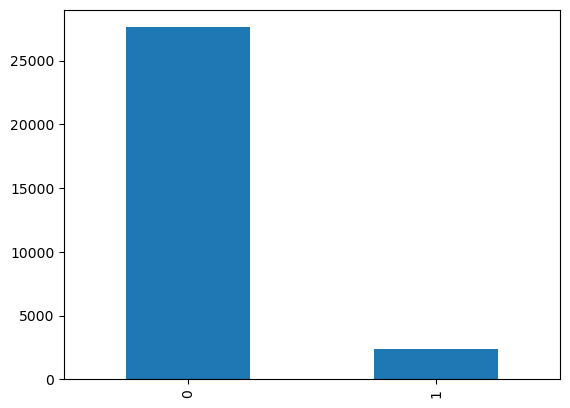

In [12]:
train['TARGET'].value_counts().plot.bar()

In [13]:
df = train.append(test)
# pd.concat([train, test])

In [14]:
del train, test;

In [15]:
gc.collect()

17

# preprocessing

In [16]:
df = df[df['CODE_GENDER'] != 'XNA']

In [17]:
df = df[df['AMT_INCOME_TOTAL'] < 20000000]

In [18]:
df['DAYS_EMPLOYED'] # 고용된 날 수

0          -637
1         -1188
2          -225
3         -3039
4         -3038
          ...  
29995    365243
29996     -2642
29997      -871
29998     -1955
29999      -633
Name: DAYS_EMPLOYED, Length: 59999, dtype: int64

In [19]:
(df['DAYS_EMPLOYED'] == 365243).sum()

11120

In [20]:
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)

In [21]:
df['DAYS_EMPLOYED']

0        -637.0
1       -1188.0
2        -225.0
3       -3039.0
4       -3038.0
          ...  
29995       NaN
29996   -2642.0
29997    -871.0
29998   -1955.0
29999    -633.0
Name: DAYS_EMPLOYED, Length: 59999, dtype: float64

In [22]:
df['DAYS_LAST_PHONE_CHANGE'].replace(0, np.nan, inplace=True)

In [23]:
df['DAYS_LAST_PHONE_CHANGE'].head(20)

0    -1134.0
1     -828.0
2     -815.0
3     -617.0
4    -1106.0
5    -2536.0
6    -1562.0
7    -1070.0
8        NaN
9    -1673.0
10    -844.0
11   -2396.0
12   -2370.0
13      -4.0
14    -188.0
15    -925.0
16      -3.0
17   -2811.0
18    -239.0
19   -1850.0
Name: DAYS_LAST_PHONE_CHANGE, dtype: float64

In [24]:
docs = [f for f in df.columns if 'FLAG_DOC' in f]

In [25]:
df['DOCUMENT_COUNT'] = df[docs].sum(axis=1)

In [26]:
df['DOCUMENT_COUNT'].value_counts()

1    55877
0     3343
2      762
3       17
Name: DOCUMENT_COUNT, dtype: int64

In [27]:
df[docs].kurtosis(axis=1)

0        20.0
1        20.0
2         0.0
3        20.0
4        20.0
         ... 
29995    20.0
29996    20.0
29997    20.0
29998    20.0
29999    20.0
Length: 59999, dtype: float64

In [28]:
df['NEW_DOC_KURT'] = df[docs].kurtosis(axis=1)

In [29]:
def get_age_label(days_birth):
    
    age_years = -days_birth / 365
    if age_years < 27: return 1
    elif age_years < 30: return 1
    elif age_years < 50: return 2
    elif age_years < 65: return 3
    elif age_years < 99: return 4
    elif age_years < 27: return 5
    else: return 0
    

In [30]:
- df['DAYS_BIRTH'] / 365

0        25.920548
1        45.931507
2        52.180822
3        52.068493
4        54.608219
           ...    
29995    59.273973
29996    49.200000
29997    54.679452
29998    27.898630
29999    46.764384
Name: DAYS_BIRTH, Length: 59999, dtype: float64

In [31]:
df['AGE_RANGE'] = df['DAYS_BIRTH'].apply(lambda x: get_age_label(x))

In [32]:
df['EXT_SOURCES_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
df['EXT_SOURCES_PROD_1_2'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2']
df['EXT_SOURCES_PROD_1_3'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_3']

In [33]:
df['EXT_SOURCE_1'] * 2 + df['EXT_SOURCE_2'] *1 + df['EXT_SOURCE_3'] * 3
# 2, 1, 3 을 곱하는 이유 -> 제일 좋아서

0        0.847150
1             NaN
2             NaN
3             NaN
4             NaN
           ...   
29995    4.367247
29996         NaN
29997    2.578346
29998         NaN
29999         NaN
Length: 59999, dtype: float64

In [34]:
# np.warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')
warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')  # 수정된 부분

In [35]:
for function_name in ['min', 'max', 'mean', 'nanmedian', 'var','max']:
    feature_name = 'EXT_SOURCES_{}'.format(function_name.upper())
    df[feature_name] = eval('np.{}'.format(function_name))(df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']], axis=1)

In [36]:
df['CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']

In [37]:
df['CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']

In [38]:
df['ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']

In [39]:
df['CREDIT_TO_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']

In [40]:
df['INCOME_TO_EMPLOYED_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_EMPLOYED']

In [41]:
df['INCOME_TO_BIRTH_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_BIRTH']

In [44]:
df['EMPLOYED_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
df['ID_TO_BIRTH_RATIO'] = df['DAYS_ID_PUBLISH'] / df['DAYS_BIRTH']
df['CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
df['CAR_TO_EMPLOYED_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
df['PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']